# In this notebook, we are going to implement MLP model to analysis the data
## https://en.wikipedia.org/wiki/Multilayer_perceptron


In [37]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image


In [38]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [39]:
#preprocess labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id     dx    dx_type   age     sex  \
4075  HAM_0000017  ISIC_0025894     nv  follow_up  50.0  female   
7291  HAM_0004222  ISIC_0031757     nv      histo  15.0  female   
9928  HAM_0006560  ISIC_0028063  akiec      histo  50.0    male   
506   HAM_0005968  ISIC_0024758    bkl      histo  70.0  female   
5865  HAM_0003271  ISIC_0031850     nv  follow_up  50.0  female   

         localization  label  
4075  lower extremity      5  
7291          abdomen      5  
9928             face      0  
506              face      2  
5865            trunk      5  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [81]:
import math
#assign weight
#sum of the data
total_data = 0
num_classes = 7
for num_of_data in df['label'].value_counts():
    total_data+=num_of_data
print("total number of data: ",total_data)
print(df['label'].value_counts())
#calc weight for each class
class_weight ={}
for index, value in df.label.value_counts().iteritems():
    v1 = math.log(0.7*total_data/float(value))
    class_weight[index] = v1 if v1>1.0 else 1.0

for i in class_weight:
    print(i," ",class_weight[i])

total number of data:  10015
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
5   1.0
4   1.8403499528856415
2   1.853008349757565
1   2.6129410387060212
0   3.065204133263933
6   3.8993372465599254
3   4.110232175797936


In [41]:
from glob import glob
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [42]:
#image_64 is the actual image(resized to 64x64) store in the dataframe
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

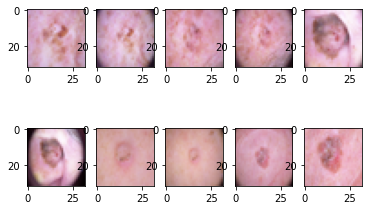

In [43]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [ ]:
#image to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split

df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
#data = data.reshape(total_data,image_size*image_size*3).astype('float32')
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.25,random_state=random.randint(1,99),stratify=label_to_one_hot)

In [6]:
#setup MLP model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Dense
num_classes = 7
dimension = image_size*image_size*3

model = Sequential()

#input Dense layer of 64x64x3 image input:
#with normal distribution + relu activation
model.add(Dense(units=1024,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.25))

#hidden layer 2
model.add(Dense(units=1024,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.25))

#hidden layer 3
model.add(Dense(units=1024,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.25))

#output Dense layer 7 classes + softmax activation
model.add(Dense(units=num_classes,kernel_initializer='normal',activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

NameError: name 'image_size' is not defined

In [7]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 256
epochs = 20

train_history = model.fit(
    x=train_data,y=train_label,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2,class_weight=class_weight)

NameError: name 'model' is not defined

In [5]:
# Train without class weight
#You can also use generator to use augmentation during training.

batch_size = 256
epochs = 20

train_history = model.fit(
    x=train_data,y=train_label,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2)

NameError: name 'model' is not defined

In [47]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

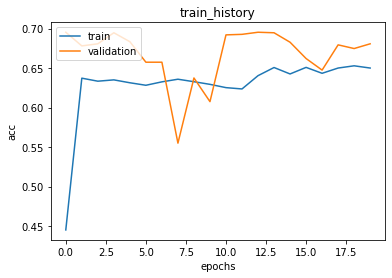

In [85]:
#plot train history
plot_train_history(train_history,'acc','val_acc')

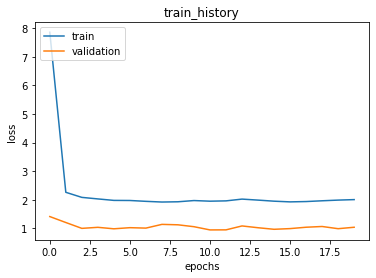

In [86]:
# plot loss
plot_train_history(train_history,'loss','val_loss')

In [87]:
#score
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

79/79 [==============================] - 0s 4ms/step - loss: 1.0702 - acc: 0.6649
Test accuracy: 0.6649361252784729


In [75]:
#predictions

prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
print(prediction_class)
prediction_label = np.argmax(test_label,axis=1)

#confusion matrix
print(pd.crosstab(prediction_label,prediction_class,rownames=['label'],colnames=['predict']))

[5 5 5 ... 5 5 5]
predict    2     5
label             
0         57    13
1        118    15
2        191    91
3         21     5
4         90   212
5        264  1402
6         10    15
